# Data Cleaning

In [2]:
import sys, os
sys.path.append('../')
# path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
# if (not (path2add in sys.path)) :
#     sys.path.append(path2add)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.cleaning import calculate_whiskers

# Data Ingestion

In [19]:
df = pd.read_csv("./CSV/predictive_maintenance.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (10000, 10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# General Look at the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
df.isna().sum().max()

0

In [6]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


### Observations:
- The dataset is very clean, with no missing data, but the column names are not formatted
- It contains 2 Id's columns, one for the unique identifier and the other contains the serial number of the product and it's type
- Two target columns are present, one for binary classification and the other for multiclass classification
- There are no extreme outliers, but the columns `Rotational speed [rpm]`, `Torque [Nm]`, and `Tool wear [min]` do have max values that are quite high in relation to the other values

### Impact:
- All columns must be renamed using "_" instead of spaces, using only lower case letters and removing all unit of measure indicator, preventing any errors that may appear as a result of these name formats 
- Both id columns must be dropped since they have no value
- The target columns can be used to see if there's any discrepancy between the number of failures, with the `Target` column indicating no failures and the `Failure Type` column indicating some type of failure

# Failure discrepancy

In [7]:
df[["Target", "Failure Type"]].value_counts()

Target  Failure Type            
0       No Failure                  9643
1       Heat Dissipation Failure     112
        Power Failure                 95
        Overstrain Failure            78
        Tool Wear Failure             45
0       Random Failures               18
1       No Failure                     9
Name: count, dtype: int64

### Observations:
- When `Target` = 0, `Failure Type` indicated a Random Failure 18 times
- When `Target` = 1, `Failure Type` indicated that there was no failure

### Impact:
- Since it's impossible to say which column is correct in cases with different results, these rows will be removed to ensure that the data is reliable

# Outilers

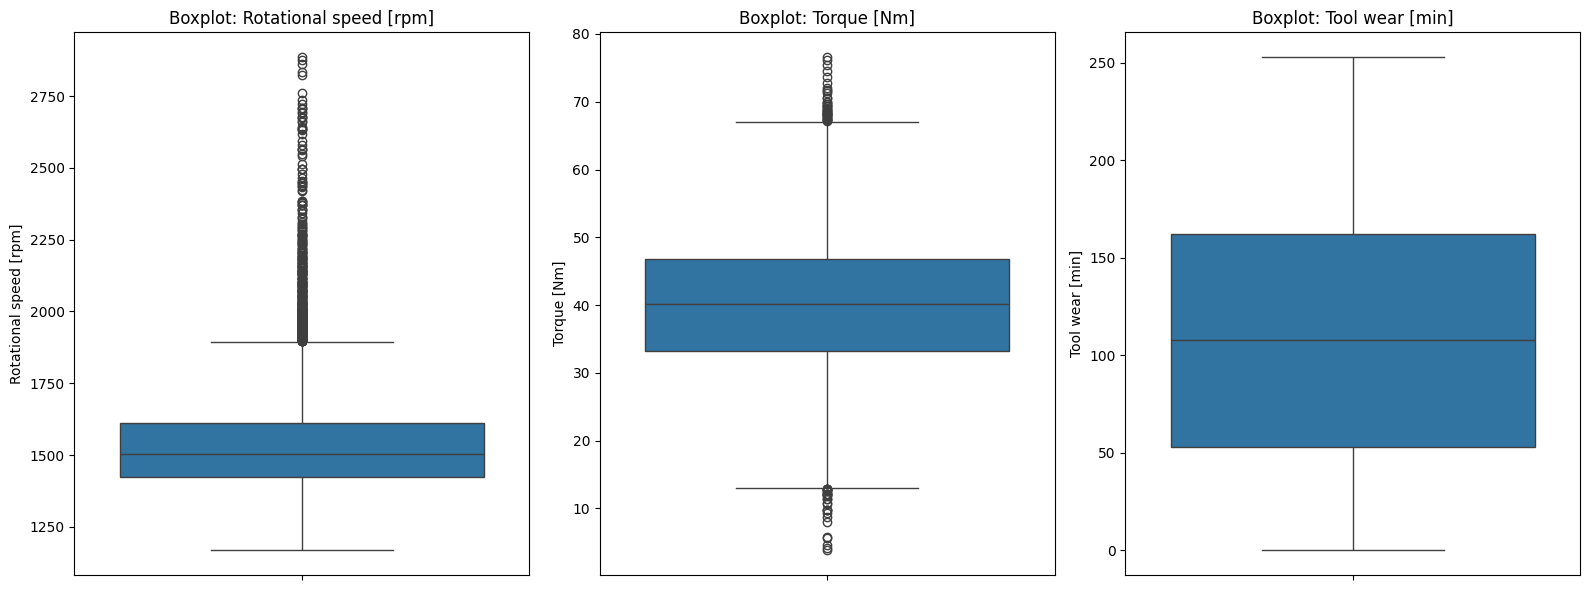

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax = ax.ravel()
columns = ["Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
for i, col in enumerate(columns):
    sns.boxplot(y=df[col], ax=ax[i])
    ax[i].set_title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

In [10]:
print(f"Rotational speed [rpm] whiskers (max, min): {calculate_whiskers(df['Rotational speed [rpm]'])}")
print(f"Torque [Nm] whiskers (max, min): {calculate_whiskers(df['Torque [Nm]'])}")

Rotational speed [rpm] whiskers (max, min): (1895.5, 1139.5)
Torque [Nm] whiskers (max, min): (67.19999999999999, 12.800000000000011)


In [11]:
df_outliers = df[(df['Rotational speed [rpm]'] > 1895.5) | (df['Torque [Nm]'] < 12.8) | (df['Torque [Nm]'] > 67.20)]
df_outliers[["Target", "Failure Type"]].value_counts()

Target  Failure Type            
0       No Failure                  387
1       Power Failure                64
        Tool Wear Failure             4
        Overstrain Failure            2
        Heat Dissipation Failure      1
Name: count, dtype: int64

### Observations:
- The `Tool wear [min]` column doesn't have outliers
- `Rotational speed [rpm]` have a lot of outliers, but none that is extreme
- For approximately 18% of the cases where at least one of these columns marked an outlier value, the machine had a failure

### Impact:
- Since the outliers are not extreme and that failures can happen with these values, they won't be dropped

# Data Cleaning Pipeline

### Based on the analysis in this notebook, the following data cleaning steps will be taken:
- Rename all columns to lower case, replace spaces with "_" and remove all unit of measure indicators
- Remove all id columns
- Drop all rows where the `Target` and `Failure Type` columns are showing different things

In [16]:
def cleaning_pipeline(data, save_folder, save_filename):
    """
    Perform preprocessing on the input DataFrame and save the cleaned data to a CSV file.

    Parameters:
    - data (pandas.DataFrame): The input DataFrame.
    - save_folder (str): The folder where the CSV file will be saved.
    - save_filename (str): The name of the CSV file.

    Returns:
    - processed_data (pandas.DataFrame): The preprocessed DataFrame.
    """
    data.columns = data.columns.str.lower().str.replace(r'\[.*\]', '', regex=True).str.rstrip().str.replace(' ', '_')
    data.drop(columns=["udi", "product_id"], inplace=True)
    inconsistent_rows = ((df['target'] == 0) & (df['failure_type'] != 'No Failure')) | ((df['target'] == 1) & (df['failure_type'] == 'No Failure'))
    data.drop(index=data[inconsistent_rows].index, inplace=True)

    save_path = os.path.join(save_folder, f"{save_filename}.csv")
    processed_df = data.to_csv(save_path, index=False)

    return processed_df

In [17]:
cleaning_pipeline(df, "CSV", "clean_pred_maintenance")